In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = "03_rnn_pt"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/03_rnn_pt


In [ ]:
import torch
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 2.3.1+cu121


In [ ]:
# !pip install torch==1.1.0 torchvision==0.3.0

# Recurrent Neural Network: Neural Weather Forecaster

<img src="http://drive.google.com/uc?export=view&id=139sr_X8Hi8O8s43syKDxW7UCF33X_mjh" width="600px" height="800px" />

* 이미지 출처: 네이버
<br>
많은 사람들이 아침에 집을 나서기 전에 오늘 기온이 어떤지 혹은 비가 오는지 알기 위해 일기예보를 확인합니다. 그런데 혹시 일기예보가 어떻게 이루어지는지 생각해 보신적이 있으신가요? 아직 오지도 않은 미래의 날씨를 어떻게 예측할 수 있을까요? 아마 여러분 대부분은 기상 예측과 관련된 전문적인 지식에 대해 잘 알지 못할 것입니다. 엄청난 계산능력을 갖춘 슈퍼컴퓨터가 복잡한 계산을 통해 예측을 한다는 정도는 들어보신 분들도 계실 수 있겠네요. 하지만 딥러닝을 활용할 수 있고, 지난 과거의 기후 데이터만 가지고 있으면 여러분의 PC에서도 훌륭한 일기예보 모델을 학습시킬 수 있습니다. 이번 프로젝트에서는 RNN을 직접 설계하여 24시간 후의 기온을 예측하는 문제를 해결할 것입니다.

이번 실습의 목표는 다음과 같습니다.
- RNN을 설계하여 지난 며칠 동안의 날씨 정보를 기반으로 24시간 이후의 기온을 예측한다.
- 다양한 속성의 시계열 정보를 활용하기 위해 적절한 전처리 과정을 적용한다.
- 설계한 모델의 성능을 검증하기 위해 베이스라인 모델을 도입한다.


이번 과정을 통해 얻는 최종 결과물은 아래 그림과 같습니다.

<img src="http://drive.google.com/uc?export=view&id=1UD4n1qLY2o3ayAQq-LOOiHd76qiCVAYk" width="600px" height="400px" />
<center>&lt;기온, 강수량 등 다양한 정보로 미래의 기온 예측&gt;</center></caption>


In [ ]:
import os
import glob
import csv
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import check_util.checker as checker
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.3.1+cu121
GPU 사용 가능 여부: False


In [ ]:
batch_size = 100
num_epochs = 10
learning_rate = 0.00003

In [ ]:
def preprocess(all_files):
    data_0 = [] # 기온
    data_1 = [] # 강수량
    data_2 = [] # 풍속
    data_3 = [] # 습도
    data_4 = [] # 증기압
    data_5 = [] # 이슬점 온도
    data_6 = [] # 현지 기압
    data_7 = [] # 해면 기압
    data_8 = [] # 지면 온도
    for f in all_files:
        with open(f, encoding='euc-kr') as c:
            csv_reader = csv.reader(c, delimiter=',')
            header = True
            for col in csv_reader:
                if header:
                    header = False
                    continue
                data_0.append(float(col[2])) if col[2] != '' else data_0.append(0.0)
                data_1.append(float(col[3])) if col[3] != '' else data_1.append(0.0)
                data_2.append(float(col[4])) if col[4] != '' else data_2.append(0.0)
                data_3.append(float(col[6])) if col[6] != '' else data_3.append(0.0)
                data_4.append(float(col[7])) if col[7] != '' else data_4.append(0.0)
                data_5.append(float(col[8])) if col[8] != '' else data_5.append(0.0)
                data_6.append(float(col[9])) if col[9] != '' else data_6.append(0.0)
                data_7.append(float(col[10])) if col[10] != '' else data_7.append(0.0)
                data_8.append(float(col[22])) if col[22] != '' else data_8.append(0.0)

    data = np.zeros((len(data_0), 9))
    for i, d in enumerate(data):
        data[i, 0] = data_0[i]
        data[i, 1] = data_1[i]
        data[i, 2] = data_2[i]
        data[i, 3] = data_3[i]
        data[i, 4] = data_4[i]
        data[i, 5] = data_5[i]
        data[i, 6] = data_6[i]
        data[i, 7] = data_7[i]
        data[i, 8] = data_8[i]
    return data

In [ ]:
class Dataset(Dataset):
    def __init__(self, data_dir, mode, mean=None, std=None, seq_len=480, target_delay=24, stride=5, normalize=True):
        self.mode = mode
        self.seq_len = seq_len
        self.target_delay = target_delay
        self.stride = stride
        all_files = sorted(glob.glob(os.path.join(data_dir, mode, '*')))
        self.data = preprocess(all_files)
        if mode == 'train':
            assert (mean is None) and (std is None), \
                "평균과 분산은 train 폴더의 있는 데이터로 구하기 때문에 None 으로 설정합니다."

            self.mean = np.mean(self.data, axis= 0)
            self.std = np.mean(self.data, axis= 0)

        else:
            assert (mean is not None) and (std is not None), \
                "평균과 분산은 `train_data`변수에 내장한 self.mean 과 self.std 를 사용합니다."

            self.mean = mean
            self.std = std

        if normalize:
            self.data = (self.data - self.mean) / self.std

    def __getitem__(self, index):
        index = index * self.stride
        sequence = self.data[index:index + self.seq_len]         #
        target = self.data[index + self.seq_len + self.target_delay - 1][0]
        target = np.expand_dims(target, axis=0)
        return sequence, target

    def __len__(self):
        max_idx = len(self.data) - self.seq_len - self.target_delay
        num_of_idx = max_idx // self.stride
        return num_of_idx

In [ ]:
data_dir = './data/climate_seoul'
train_data = Dataset(data_dir, 'train', mean=None, std=None)
val_data = Dataset(data_dir, 'val', mean=train_data.mean, std=train_data.std)
test_data = Dataset(data_dir, 'test', mean=train_data.mean, std=train_data.std)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

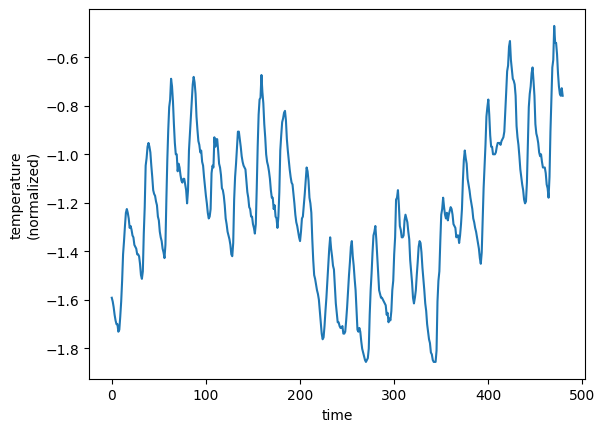

In [ ]:
temp = train_data[0][0]
temp = temp[:, 0]
plt.plot(range(len(temp)), temp)
plt.xlabel('time')
plt.ylabel('temperature\n(normalized)')
plt.show()

In [ ]:
def eval_baseline(data_loader, criterion):
    total_loss = 0
    cnt = 0
    for step, (sequence, target) in enumerate(data_loader):
        pred = torch.unsqueeze(sequence[: -1,0], dim=1)
        loss = criterion(pred, target)
        total_loss += loss
        cnt += 1
    avrg_loss = total_loss / cnt
    print('Baseline Average Loss: {:.4f}'.format(avrg_loss))
    return avrg_loss.item()

In [ ]:
baseline_loss = eval_baseline(test_loader, nn.MSELoss())

Baseline Average Loss: 7.7303


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([99, 1, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
for i in range(15):
    data_idx = np.random.randint(len(test_data))
    pred = test_data[data_idx][0][-1, 0]
    pred = pred * test_data.std[0] + test_data.mean[0]  # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target = test_data[data_idx][1][0] * test_data.std[0] + test_data.mean[0]  # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    print('예측 기온: {:.1f} / 실제 기온: {:.1f}'.format(pred, target))

예측 기온: 24.6 / 실제 기온: 26.6
예측 기온: 11.3 / 실제 기온: 11.5
예측 기온: 25.8 / 실제 기온: 26.2
예측 기온: 2.4 / 실제 기온: 0.7
예측 기온: 12.4 / 실제 기온: 15.9
예측 기온: 17.4 / 실제 기온: 18.2
예측 기온: 3.5 / 실제 기온: 5.9
예측 기온: 24.3 / 실제 기온: 26.7
예측 기온: 2.6 / 실제 기온: 3.6
예측 기온: 22.7 / 실제 기온: 21.9
예측 기온: 22.8 / 실제 기온: 24.7
예측 기온: 24.7 / 실제 기온: 26.0
예측 기온: 30.5 / 실제 기온: 25.9
예측 기온: 24.4 / 실제 기온: 21.6
예측 기온: 29.8 / 실제 기온: 28.6


In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, hidden_size=100, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size = 9, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, batch_first = True)
        self.fc = nn.Linear(self.hidden_size, 1)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, cell

    def forward(self, x):
        # hidden, cell state init
        h, c = self.init_hidden(x.size(0))
        h, c = h.to(x.device), c.to(x.device)
        out, (h, c) = self.lstm(x,(h,c))
        final_output = self.fc(out[:, -1, :])
        return final_output


In [ ]:
def train(num_epochs, model, data_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.type(torch.float32)
            target = target.type(torch.float32)
            sequence, target = sequence.to(device), target.to(device)

            outputs = model(sequence)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))

        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [ ]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.type(torch.float32)
            target = target.type(torch.float32)
            sequence, target = sequence.to(device), target.to(device)
            outputs = model(sequence)
            loss = criterion(outputs, target)
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}'.format(epoch, avrg_loss))
    model.train()
    return avrg_loss

In [ ]:
def test(model, data_loader, criterion, baseline_loss, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.type(torch.float32)
            target = target.type(torch.float32)
            sequence, target = sequence.to(device), target.to(device)
            outputs = model(sequence)
            loss = criterion(outputs, target)
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Test  Average Loss: {:.4f}  Baseline Loss: {:.4f}'.format(avrg_loss, baseline_loss))

    if avrg_loss < baseline_loss:
        print('베이스라인 성능을 뛰어 넘었습니다!')
    else:
        print('아쉽지만 베이스라인 성능을 넘지 못했습니다.')

In [ ]:
def save_model(model, saved_dir, file_name='best_model.pt'):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point, output_path)

In [ ]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정

model = SimpleLSTM().to(device)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

val_every = 1
saved_dir = './saved/LSTM'

In [ ]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/10], Step [25/139], Loss: 0.7432
Epoch [1/10], Step [50/139], Loss: 0.7696
Epoch [1/10], Step [75/139], Loss: 0.6753
Epoch [1/10], Step [100/139], Loss: 0.5788
Epoch [1/10], Step [125/139], Loss: 0.6512
Start validation #1
Validation #1  Average Loss: 0.4303
Best performance at epoch: 1
Save model in ./saved/LSTM
Epoch [2/10], Step [25/139], Loss: 0.5205
Epoch [2/10], Step [50/139], Loss: 0.4011
Epoch [2/10], Step [75/139], Loss: 0.3895
Epoch [2/10], Step [100/139], Loss: 0.3300
Epoch [2/10], Step [125/139], Loss: 0.3023
Start validation #2
Validation #2  Average Loss: 0.2337
Best performance at epoch: 2
Save model in ./saved/LSTM
Epoch [3/10], Step [25/139], Loss: 0.2192
Epoch [3/10], Step [50/139], Loss: 0.1933
Epoch [3/10], Step [75/139], Loss: 0.1715
Epoch [3/10], Step [100/139], Loss: 0.1295
Epoch [3/10], Step [125/139], Loss: 0.1645
Start validation #3
Validation #3  Average Loss: 0.1335
Best performance at epoch: 3
Save model in ./saved/LSTM
Epoch [4/10

In [ ]:
model_path = './saved/LSTM/best_model.pt'
# model_path = './saved/pretrained/LSTM/best_model.pt' # 모델 학습을 끝까지 진행하지 않은 경우에 사용
model = SimpleLSTM().to(device)

checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['net']
model.load_state_dict(model)

In [ ]:
for i in range(15):
    data_idx = np.random.randint(len(test_data))
    sequence = test_data[data_idx][0]
    sequence = torch.Tensor(sequence).unsqueeze(0).to(device)

    pred = model(sequence)
    pred = pred.item() * test_data.std[0] + test_data.mean[0]
    target = test_data[data_idx][1][0] * test_data.std[0] + test_data.mean[0]
    print('예측 기온: {:.1f} / 실제 기온: {:.1f}'.format(pred, target))

예측 기온: 13.2 / 실제 기온: 23.0
예측 기온: 13.3 / 실제 기온: 16.9
예측 기온: 13.0 / 실제 기온: 18.6
예측 기온: 13.0 / 실제 기온: 14.6
예측 기온: 13.0 / 실제 기온: 4.2
예측 기온: 13.3 / 실제 기온: -7.4
예측 기온: 13.3 / 실제 기온: -6.2
예측 기온: 12.7 / 실제 기온: 22.6
예측 기온: 13.6 / 실제 기온: -5.3
예측 기온: 13.5 / 실제 기온: 7.9
예측 기온: 6.1 / 실제 기온: 24.9
예측 기온: 13.3 / 실제 기온: 5.0
예측 기온: 13.0 / 실제 기온: 7.5
예측 기온: 12.8 / 실제 기온: 22.7
예측 기온: 13.2 / 실제 기온: -9.7


- 날씨와 같은 시계열 정보를 다룰 수 있다.
- RNN을 설계하고 시간 순서상 미래의 정보를 예측하는 모델을 학습시킬 수 있다.
- 상식적인 수준의 베이스라인을 도입하여 학습한 모델의 성능을 검증할 수 있다.

---